# NDVI Calculation

In [1]:
import sys
sys.path.append('../')

In [2]:
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import lithops
import time
import shutil
import os
import gc
import datetime
import math
import collections
from rasterio.io import MemoryFile
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from IPython import display

import cloudbutton_geospatial.s2froms3 as s2froms3
from cloudbutton_geospatial.utils import notebook as notebook_utils
from cloudbutton_geospatial.io_utils.ndvi import get_ndvi_params, ndvi_calculation, ndvi_tile_sentinel, get_subset_raster, lonlat_to_utm, get_poly_within
from cloudbutton_geospatial.io_utils.plot import tiff_overview, plot_map

%matplotlib inline

## Input parameters

Select the date interval in which tiles will be processed:

In [3]:
default_from = datetime.date(year=2019, month=9, day=17)
default_to = datetime.date(year=2020, month=9, day=16)

from_date, to_date = notebook_utils.pick_date_range(default_from, default_to)

DatePicker(value=datetime.date(2019, 9, 17), description='From day', step=1)

DatePicker(value=datetime.date(2020, 9, 16), description='To day', step=1)

Select the tile's cloud percentage threshold:

In [4]:
percentage = notebook_utils.pick_percentage_slider()

IntSlider(value=15, continuous_update=False, description='Percentage of cloudiness')

## Find tiles

Select the area which delimites the tiles you want to process (left click to mark a point in the map, right click to erase current selection):

In [5]:
map_region = notebook_utils.MapRegion(center=(39.60595289727246, -122.82804126978336))

Map(center=[39.60595289727246, -122.82804126978336], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [6]:
coords = []
lats = []
lons = []
points = []

for value in map_region.get_region()[:-1]:
    coords.append(value)
    lats.append(value[1])
    lons.append(value[0])

start_date = from_date.value  # Start date to search images
end_date = to_date.value  # End date to search images
what = ['B04', 'B08']  # What we want to download
cc = percentage.value  # Minimum cloud cover on each image, 25 is 25%

for lon, lat in zip(lons, lats):
    points.append([lon, lat])
    print([lon, lat], start_date, end_date, what, cc)

In [7]:
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [8]:
i, p = 0, 0

while i != len(points):
    p = i + 1
    while p != len(points):
        dis = distance(points[i], points[p])
        divisions = int(dis / 100)
        # If the zones are separated by more than 100 km, generate intermediate zones
        if divisions > 0:
            toSum = [(points[i][0] - points[p][0]) / (divisions + 1) , (points[i][1] - points[p][1]) / (divisions + 1)]
            while divisions != 0:
                point = points[i][0] - (toSum[0] * divisions)
                # Not add duplicated lons/lats
                if point not in lons:
                    lons.append(points[i][0] - (toSum[0] * divisions))
                    lats.append(points[i][1] - (toSum[1] * divisions))
                divisions = divisions - 1
        p = p + 1 
    i = i + 1

In [9]:
start_date = from_date.value  # Start date to search images
end_date = to_date.value  # End date to search images
what = ['B04', 'B08']  # What we want to download
cc = percentage.value  # Minimum cloud cover on each image, 25 is 25% (15 by default)

In [10]:
# Demonstration: Californa tile coords
cali_coords = [
    [38.510161585585045, -122.99194335937501],
    [36.071996052851325, -121.25610351562501],
    [36.96374622851412, -121.46484375000001],
    [37.575739257598414, -121.55273437500001],
    [39.15202827678992, -122.62939453125001],
    [39.703620879017976, -123.12377929687501],
    [36.74397383313428, -119.94873046875001],
    [38.472809653752314, -121.60766601562501]
]

## Get Sentinel-2 packages

In [11]:
scenes_f1 = []
scenes_f2 = []

# To use the demonstration tile coords, coment this line to use teh coords obtained from the map before
coords = cali_coords

for latency, longitude in coords:
    try:
        # Get scenes from intital date
        f1 = s2froms3.get_scene_list(lon=longitude, lat=latency, start_date=start_date, end_date=start_date,
        what=what, cloud_cover_le=cc)
        print(f1)

        # Get scenes from end date
        f2 = s2froms3.get_scene_list(lon=longitude, lat=latency, start_date=end_date, end_date=end_date,
        what=what, cloud_cover_le=cc)
        print(f2)

        # Not add duplicated scenes
        if len(scenes_f1) == 0 or f1 not in scenes_f1:
            scenes_f1.append(f1)
            scenes_f2.append(f2)

            print(f'Found scenes {start_date}:', f1)
            print(f'Found scenes {end_date}:', f2)
            print(f'Lon: {longitude}, Lat: {latency}')
            print(f'Cell: {f1[0][0].split("/")[2]} {f1[0][0].split("/")[3]} {f1[0][0].split("/")[4]}\n')
    
    except Exception:
        pass

if len(scenes_f1) == 0:
    raise Exception('No data found')

scene = scenes_f1[-1][-1]
scene_band = rasterio.open('s3://'+scene[0])
windows = list(scene_band.block_windows())

[('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B08.tif')]
[('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_1_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_1_L2A/B08.tif'), ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_0_L2A/B08.tif')]
Found scenes 2019-09-17: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B08.tif')]
Found scenes 2020-09-16: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_1_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_1_L2A/B08.tif'), ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_0_L2A

In [12]:
tile_band_keys = [tup[0] for tup in scenes_f1]
print(tile_band_keys)

[('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B08.tif'), ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FF/2019/9/S2A_10SFF_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FF/2019/9/S2A_10SFF_20190917_0_L2A/B08.tif'), ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FG/2019/9/S2A_10SFG_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FG/2019/9/S2A_10SFG_20190917_0_L2A/B08.tif'), ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EJ/2019/9/S2A_10SEJ_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EJ/2019/9/S2A_10SEJ_20190917_0_L2A/B08.tif'), ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/DJ/2019/9/S2A_10SDJ_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/DJ/2019/9/S2A_10SDJ_20190917_0_L2A/B08.tif'), ('sentinel-cogs/sentinel-s2-l2a-cogs/11/S/KA/2019/9/S2A_11SKA_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/11/S/K

In [13]:
fexec = lithops.FunctionExecutor(
        backend='aws_lambda',
        storage='aws_s3',
        log_level='INFO',
        runtime_memory=4096,
        runtime='cloudbutton-ndvi:01'  # Runtime for AWS Lambda
)

2023-10-09 16:21:37,786 [INFO] config.py:134 -- Lithops v2.9.0
2023-10-09 16:21:38,262 [INFO] aws_s3.py:67 -- S3 client created - Region: us-east-1
2023-10-09 16:21:38,888 [INFO] aws_lambda.py:94 -- AWS Lambda client created - Region: us-east-1


In [14]:
def get_tile_meta(key, foo):
    with rasterio.open('s3://'+key) as src:
        x1, y1 = src.profile['transform'] * (0, 0)
        x2, y2 = src.profile['transform'] * (src.profile['width'], src.profile['height'])
    return key, (x1, y1), (x2, y2)

In [15]:
fs_meta = fexec.map(get_tile_meta, tile_band_keys)
tiles_meta = fexec.get_result(fs=fs_meta)

2023-10-09 16:21:38,949 [INFO] invokers.py:108 -- ExecutorID 80dff8-0 | JobID M000 - Selected Runtime: cloudbutton-ndvi:01 - 4096MB
2023-10-09 16:21:39,659 [INFO] invokers.py:172 -- ExecutorID 80dff8-0 | JobID M000 - Starting function invocation: get_tile_meta() - Total: 7 activations
2023-10-09 16:21:39,674 [INFO] invokers.py:208 -- ExecutorID 80dff8-0 | JobID M000 - View execution logs at /tmp/lithops-jordi/logs/80dff8-0-M000.log
2023-10-09 16:21:39,678 [INFO] wait.py:97 -- ExecutorID 80dff8-0 - Getting results from 7 function activations


    0%|          | 0/7  

2023-10-09 16:21:45,755 [INFO] executors.py:612 -- ExecutorID 80dff8-0 - Cleaning temporary data


In [16]:
tiles_meta

[('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B04.tif',
  (499980.0, 4300020.0),
  (609780.0, 4190220.0)),
 ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FF/2019/9/S2A_10SFF_20190917_0_L2A/B04.tif',
  (600000.0, 4100040.0),
  (709800.0, 3990240.0)),
 ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FG/2019/9/S2A_10SFG_20190917_0_L2A/B04.tif',
  (600000.0, 4200000.0),
  (709800.0, 4090200.0)),
 ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EJ/2019/9/S2A_10SEJ_20190917_0_L2A/B04.tif',
  (499980.0, 4400040.0),
  (609780.0, 4290240.0)),
 ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/DJ/2019/9/S2A_10SDJ_20190917_0_L2A/B04.tif',
  (399960.0, 4400040.0),
  (509760.0, 4290240.0)),
 ('sentinel-cogs/sentinel-s2-l2a-cogs/11/S/KA/2019/9/S2A_11SKA_20190917_0_L2A/B04.tif',
  (199980.0, 4100040.0),
  (309780.0, 3990240.0)),
 ('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FH/2019/9/S2A_10SFH_20190917_0_L2A/B04.tif',
  (600000.0, 4300020.0),
  (709800.0, 4190220.0))]

In [37]:
regions = [(tile_id, bound1, bound2,
            int(tile_id.split('/')[7].split('_')[1][:2]),
            True) for tile_id, bound1, bound2 in tiles_meta]

# notebook_utils.MapRegion(regions=regions, center=(38.141080, -122.126583), zoom=6)

In [18]:
import matplotlib 
def calculate_ndvi(scene, ij_window, storage):
    ij, window = ij_window
    band_4_s3_loc, band_8_s3_loc = scene
    band_path = band_4_s3_loc.split('/')
    ndvi_local = f'/tmp/{band_path[7]}_{ij}_NDVI.tif'
    jpg_local = f'/tmp/{band_path[7]}_{ij}_NDVI.jpg'

    # generate nir and red objects as arrays in float64 format
    band4 = rasterio.open('s3://'+band_4_s3_loc)  # red
    band8 = rasterio.open('s3://'+band_8_s3_loc)  # nir

    profile = band4.profile
    profile.update(dtype='float64')
    profile.update(width=window.width)
    profile.update(height=window.height)

    with rasterio.open(ndvi_local, 'w', **profile) as dst:
        red = band4.read(1, window=window).astype('float64')
        nir = band8.read(1, window=window).astype('float64')
        ndvi = (np.where((nir + red) == 0., 0, (nir - red) / (nir + red))).astype('float64')
        ndvi_mean = np.mean(ndvi, axis=0)
        dst.write(ndvi, 1)
        ndvi[0][0] = -1
        ndvi[0][1] = 1
        plt.imsave(jpg_local, ndvi, cmap="RdYlGn")

    with open(jpg_local, 'rb') as jpg_temp:
        co_jpg = storage.put_cloudobject(jpg_temp.read(), key=jpg_local.replace('/tmp/', ''))

    return ndvi_local, ndvi_mean, co_jpg


def compute_ndvi_diff(old_scene, new_scene, ij_window, storage):
    ij, window = ij_window
    band_path = new_scene[0].split('/')
    jpg_diff_local = f'/tmp/{band_path[7]}_{ij}_NDVI_DIFF.jpg'
    key = old_scene[0].split('/')[7].rsplit('_', 3)[0]

    ndvi_local_f1, ndvi_mean_f1, co_jpg_f1 = calculate_ndvi(old_scene, ij_window, storage)
    ndvi_local_f2, ndvi_mean_f2, co_jpg_f2 = calculate_ndvi(new_scene, ij_window, storage)

    ndvi_old = rasterio.open(ndvi_local_f1)
    ndvi_new = rasterio.open(ndvi_local_f2)

    profile = ndvi_old.profile
    profile.update(dtype='float64')
    profile.update(width=window.width)
    profile.update(height=window.height)

    no = ndvi_old.read(1).astype('float64')
    nn = ndvi_new.read(1).astype('float64')
    ndvi_cmp = ((nn - no) * (nn + no)).astype('float64')
    ndvi_cmp[0][0] = -1
    ndvi_cmp[0][1] = 1
    plt.imsave(jpg_diff_local, ndvi_cmp, cmap="RdYlGn")

    with open(jpg_diff_local, 'rb') as jpg_diff_file:
        co_jpg_diff = storage.put_cloudobject(jpg_diff_file, key=jpg_diff_local.replace('/tmp/', ''))

    return key, ij_window, co_jpg_f1, co_jpg_f2, co_jpg_diff

Using the selected parameters, get the identifiers of the selected tiles from Sentinel-2:

In [19]:
fexec = lithops.FunctionExecutor(
        backend='aws_lambda',
        storage='aws_s3',
        log_level='INFO',
        runtime_memory=4096,
        runtime='cloudbutton-ndvi:01'  # Runtime for AWS Lambda
)

2023-10-09 16:21:45,919 [INFO] config.py:134 -- Lithops v2.9.0
2023-10-09 16:21:45,948 [INFO] aws_s3.py:67 -- S3 client created - Region: us-east-1
2023-10-09 16:21:46,561 [INFO] aws_lambda.py:94 -- AWS Lambda client created - Region: us-east-1


In [20]:
iterdata = []
for scene_f1, scene_f2 in zip(scenes_f1, scenes_f2):
    for wd in windows:
        iterdata.append((scene_f1[0], scene_f2[0], wd))

In [21]:
fs = fexec.map(compute_ndvi_diff, iterdata)
results = fexec.get_result(fs)

2023-10-09 16:21:46,592 [INFO] invokers.py:108 -- ExecutorID 80dff8-1 | JobID M000 - Selected Runtime: cloudbutton-ndvi:01 - 4096MB
2023-10-09 16:21:47,445 [INFO] invokers.py:172 -- ExecutorID 80dff8-1 | JobID M000 - Starting function invocation: compute_ndvi_diff() - Total: 847 activations
2023-10-09 16:21:49,013 [INFO] invokers.py:208 -- ExecutorID 80dff8-1 | JobID M000 - View execution logs at /tmp/lithops-jordi/logs/80dff8-1-M000.log
2023-10-09 16:21:49,113 [INFO] wait.py:97 -- ExecutorID 80dff8-1 - Getting results from 847 function activations


    0%|          | 0/847  

2023-10-09 16:22:23,704 [INFO] executors.py:612 -- ExecutorID 80dff8-1 - Cleaning temporary data


In [22]:
grouped_results = collections.defaultdict(list)

for res in results:
    key, ij_window, co_jpg_f1, co_jpg_f2, co_jpg_diff = res
    grouped_results[key].append((ij_window, co_jpg_f1, co_jpg_f2, co_jpg_diff))

In [23]:
grouped_results.keys()

dict_keys(['S2A_10SEH', 'S2A_10SFF', 'S2A_10SFG', 'S2A_10SEJ', 'S2A_10SDJ', 'S2A_11SKA', 'S2A_10SFH'])

## Get and plot the computed jpg diff tile image

In [24]:
def get_jpg(data):
    file = '_'.join(data[0][1].key.split('_')[:5])
    
    if 'DIFF' in data[0][1].key:
        out_file = f'AwsData/{file}_NDVI_DIFF.jpg'
    else:
        out_file = f'AwsData/{file}_NDVI.jpg'
        
    jpgs = {}

    def get_window(data):
        ij_window, co_jpg = data
        row = ij_window[0][0]
        col = ij_window[0][1]
        jpg_stream = fexec.storage.get_cloudobject(co_jpg, stream=True)

        if row not in jpgs:
            jpgs[row] = [None]*11

        jpgs[row][col] = Image.open(jpg_stream)

    with ThreadPoolExecutor(max_workers=16) as ex:
        fs = list(ex.map(get_window, data))

    new_im = Image.new('RGB', (scene_band.width, scene_band.height))

    x_offset = 0
    y_offset = 0

    for row in sorted(jpgs.keys()):
        for im in jpgs[row]:
            new_im.paste(im, (x_offset, y_offset))
            x_offset += im.size[0]
        x_offset = 0
        y_offset += im.size[1]
        
    thumbnail_zise = (640, 640)
    new_im.thumbnail(thumbnail_zise)

    # fig = plt.figure(figsize=(10, 10))
    # plt.title(out_file)
    # plt.imshow(new_im)
    images[out_file] = new_im

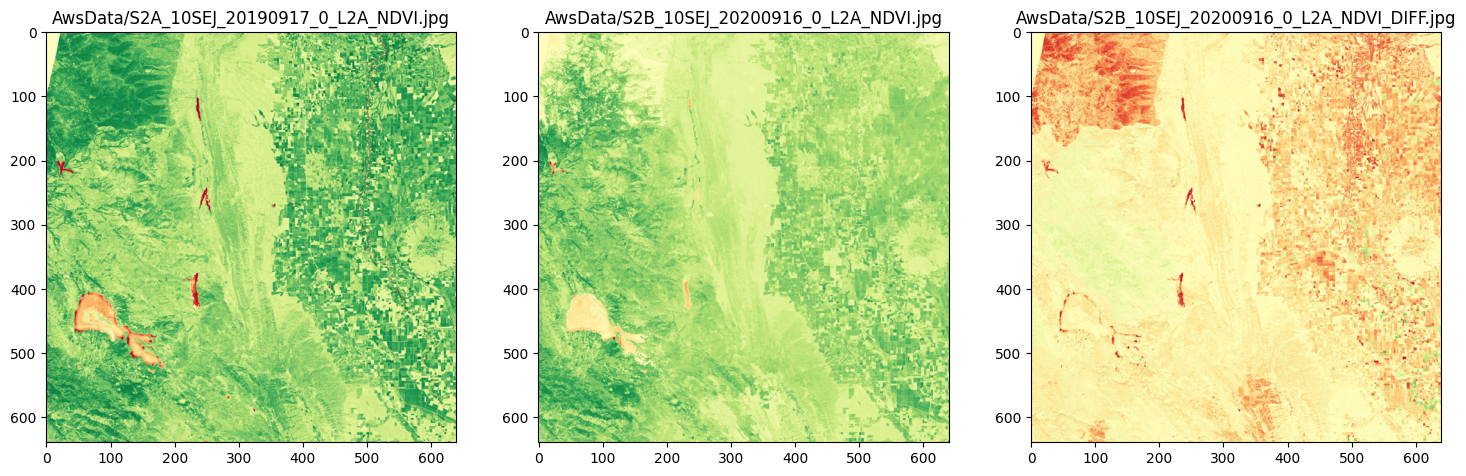

In [25]:
co_jpgs_f1 = [(res[0], res[1]) for res in grouped_results['S2A_10SEJ']]
co_jpgs_f2 = [(res[0], res[2]) for res in grouped_results['S2A_10SEJ']]
co_jpgs_diff = [(res[0], res[3]) for res in grouped_results['S2A_10SEJ']]

images = {}
with ThreadPoolExecutor(max_workers=3) as ex:
    fs = list(ex.map(get_jpg, [co_jpgs_f1, co_jpgs_f2, co_jpgs_diff]))

f, ax = plt.subplots(1,3, figsize=(18, 18))
i = 0
for j in sorted(images.keys()):
    ax[i].set_title(j)
    ax[i].imshow(images[j])
    i = i+1
plt.show() 

## KPIs

In [26]:
fexec.plot(dst=fexec.executor_id)

2023-10-09 16:23:23,121 [INFO] executors.py:554 -- ExecutorID 80dff8-1 - Creating execution plots


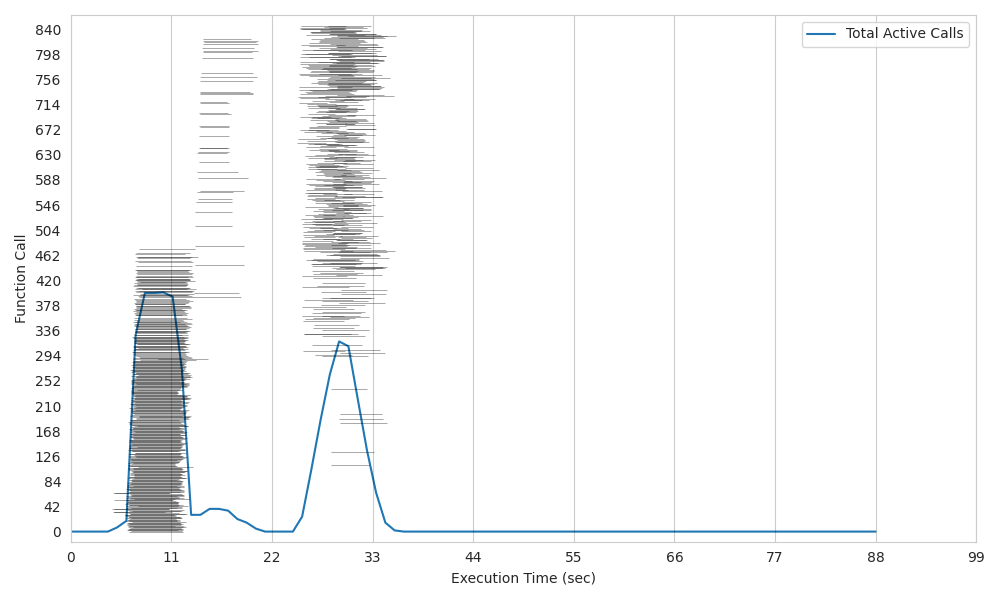

In [27]:
display.Image(filename=f'{fexec.executor_id}_histogram.png')

In [28]:
import boto3

s3client = boto3.client('s3')
total_sz = 0

for scenes in [scenes_f1, scenes_f2]:
    for scene in scenes:
        for band_path in scene[0]:
            bucket, key = band_path.split('/', 1)
            meta = s3client.head_object(Bucket=bucket, Key=key)
            total_sz += int(meta['ResponseMetadata']['HTTPHeaders']['content-length'])

stats = [f.stats for f in fexec.futures]
mean_exec_time = np.mean([stat['worker_func_exec_time'] for stat in stats])
throughput = (total_sz / 1_000_000_000) / mean_exec_time

In [29]:
print(f'Procesed {round(total_sz / 1_000_000_000, 2)} GB in {round(mean_exec_time, 2)} s => {round(throughput, 2)} GB/s')

Procesed 4.68 GB in 3.89 s => 1.2 GB/s


In [30]:
gbxms_price = 0.0000000167
sum_total_time = sum([stat['worker_exec_time'] for stat in stats]) * 1000
price = gbxms_price * sum_total_time * 1  # Price GB/ms * sum of times in ms * 1 GB

In [31]:
print(f'Experiment total price is {round(price, 3)} USD')

Experiment total price is 0.069 USD
